In [1]:
import sys
sys.path.append('O:\\68707\\JoelHoward\\DataAnalysis\\QuantumDataProcessModule')
import qdpm
sys.path.append(r'O:\68707\JoelHoward\DataAnalysis')

from qutip import ket2dm, identity, Qobj, tensor, basis, average_gate_fidelity, to_super, choi_to_super, sigmax, sigmay, sigmaz, qeye
from qutip.qip.operations import rx, ry, cphase, rz

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from pathlib import Path
%matplotlib inline

sys.path.append("O:\\68707\\JoelHoward\\OptimalControl")
import NQubitSystem_qutip as NQS_QT
sys.path.append('O:\\68707\\JoelHoward\\PulseShaping')
import AdvancedWaveforms_JH as wfm_adv
from WaveformConstructorPrimitives_JH import *
from pulseGenFuncs import Paths

sys.path.append('O:\\68707\\JoelHoward\\OptimalControl\\AlexOptim_JH')
from optim_gate_gauss_core import NielsenFidelity, evolution, gate

import torch
from forest.benchmarking.operator_tools import kraus2pauli_liouville
from copy import deepcopy

In [2]:
preparation = [identity(2),
                   rx(np.pi),
                   ry(np.pi/2),
                   ry(-np.pi/2),
                   rx(-np.pi/2),
                   rx(np.pi/2)]
rotation = [identity(2), 
            rx(-np.pi/2), 
            ry(np.pi/2)]
init_state = [basis(2,0), basis(2, 0)]

In [3]:
qSys = NQS_QT.NQubitSystem_QT(Path(r'C:\Users\68707\Desktop\LV_JH\Experiments\JH\Cooldown_2022_01_10\SSB\CNOT\7.5MHz\20Points\gateData_allRepeats\G0\results\gate\2022-03-11_0'))
qSys.numLevels = 2

ket00 = qSys.qutipState([0,0])
ket01 = qSys.qutipState([0,1])
ket10 = qSys.qutipState([1,0])
ket11 = qSys.qutipState([1,1])

basePath = Path(r"C:\Users\68707\Desktop\LV_JH\Experiments\JH\Cooldown_2022_01_10\SSB\CNOT\7.5MHz\20Points")
gateDataPath = basePath / 'gates.json'

# Single Gate Inspection

In [4]:
# gateIndex = 0
# studyPaths = Paths(basePath / ('G'+str(gateIndex)))
# tomo = qdpm.ProcessTomography(qdpm.Experiment(studyPaths.resultsPath('2022-02-21_0')), init_state, preparation, rotation)
# gateExpSlice = wfm_adv.loadGates(qSys, gateDataPath)[gateIndex]
# U = NQS_QT.unitaryFromOpList(qSys.gateExpSliceToUnitaryOpList(gateExpSlice))
# U_qt = Qobj(U, dims=[[2,2],[2,2]])
# print("Fidelity between exp/theory w/ errors:",np.around(tomo.fidelity(U_qt),4))

In [5]:
# CNOT = np.array([[1, 0, 0, 0],
#                  [0, 1, 0, 0],
#                  [0, 0, 0, 1],
#                  [0, 0, 1, 0]])
# NielsenFidelity(qSys.N, torch.tensor(U), torch.tensor(CNOT, dtype=torch.cdouble))

In [6]:
# tomo._R_mle = kraus2pauli_liouville(U)
# tomo.fidelity(Qobj(CNOT, dims=[[2,2],[2,2]]))

In [7]:
# studyPath_I = Path(r"C:\Users\68707\Desktop\LV_JH\Experiments\JH\Cooldown_2022_01_10\NoSSB\ProcessTomographyTest\id")
# paths_I = Paths(studyPath_I)

# R_I = qdpm.ProcessTomography(qdpm.Experiment(paths_I.resultsPath('20220211')), init_state, preparation, rotation)._R_mle

# R_U = tomo._R_mle

# R_spamFree = qdpm.R_SPAMfree(U, R_U, R_I)

# tomo._R_mle = R_spamFree
# print("F (no errors):",np.around(tomo.fidelity(U_qt),3))

In [8]:
# expSlice = ExpSlice([Op([wfm_adv.GaussPulse(1,10,100e-9,0)]), 
#                      Op([wfm_adv.GaussPulse(0,10,100e-9,0)])])
# Exp([expSlice]).viewAll()
# CNOT = np.array([[1, 0, 0, 0],
#                  [0, 1, 0, 0],
#                  [0, 0, 0, 1],
#                  [0, 0, 1, 0]])

# U_Exp = evolution(qSys, expSlice)
# print('Theory (odeint) Unitary:')
# print(np.around(U_Exp.detach().numpy(), 3))
# print('Theory (NQS_QT) Unitary:')
# print(np.around(NQS_QT.unitaryFromOpList(qSys.gateExpSliceToUnitaryOpList(expSlice)), 3))
# print('Fidelity between theory/CNOT: ', np.around(NielsenFidelity(qSys.N, U_Exp, torch.tensor(CNOT, dtype=torch.cdouble)).item(),2))
# print("Fidelity between exp/CNOT:",np.around(tomo.fidelity(Qobj(CNOT, dims=[[2,2],[2,2]])),3))

# Plot

<ipython-input-9-7b889be63853>:29: ComplexWarning: Casting complex values to real discards the imaginary part
  tomo._R_mle = R_spamFree.astype('float64')


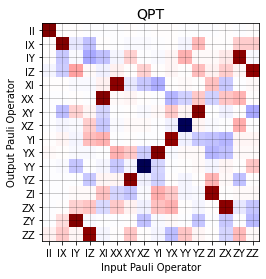

In [9]:
gates = wfm_adv.loadGates(qSys, gateDataPath)
numGates = len(gates)

TheoryGate = gate(qSys, 'CNOT').numpy()

studyPath_I = Path(r"C:\Users\68707\Desktop\LV_JH\Experiments\JH\Cooldown_2022_01_10\SSB\ProcessTomographyTest\id")
paths_I = Paths(studyPath_I)

R_I = qdpm.ProcessTomography(qdpm.Experiment(paths_I.resultsPath('2022-03-11_0')), init_state, preparation, rotation)._R_mle

G_T = list()
G_IF_Exp_Theory = list()
G_IF_Theory_TheoryGate = list()
G_IF_Exp_TheoryGate = list()

for g_i in range(numGates):
#     print('Analyzing g'+str(g_i))
    studyPaths = Paths(basePath / 'gateData_allRepeats' / ('G'+str(g_i)))
    tomo = qdpm.ProcessTomography(qdpm.Experiment(studyPaths.resultsPath('2022-03-11_0')), init_state, preparation, rotation)
    gateExpSlice = gates[g_i]
    
    G_T.append(sum([pulse.duration for pulse in gateExpSlice.opList[0].pulseList]))

    U = NQS_QT.unitaryFromOpList(qSys.gateExpSliceToUnitaryOpList(gateExpSlice))
    U_qt = Qobj(U, dims=[[2,2],[2,2]])
    
    R_U = tomo._R_mle
    R_spamFree = qdpm.R_SPAMfree(U, R_U, R_I)
    tomo._R_mle = R_spamFree.astype('float64')

    G_IF_Exp_Theory.append(1-tomo.fidelity(U_qt))

    G_IF_Theory_TheoryGate.append(1-NielsenFidelity(qSys.N, torch.tensor(U, dtype=torch.cdouble), torch.tensor(TheoryGate, dtype=torch.cdouble)).item())
    G_IF_Exp_TheoryGate.append(1-tomo.fidelity(Qobj(TheoryGate, dims=[[2,2],[2,2]])))
    
    if g_i == 15:
        tomo.plot()
        plt.savefig('CNOT75hist_exp.png', dpi=500)
        
#         tomo.plot_theory(Qobj(TheoryGate, dims=[[2,2],[2,2]]))
#         plt.savefig('CNOT75hist_theory.png', dpi=500)

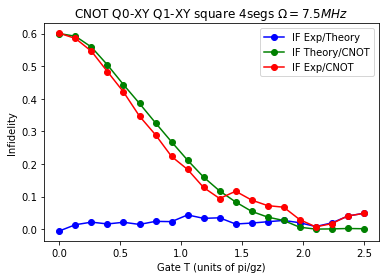

In [10]:
G_T_theory = np.array(G_T)/(np.pi/(qSys.twoQubitValues[0][1]['ZZ']*2*np.pi))

plt.plot(G_T_theory, G_IF_Exp_Theory, 'bo-', label='IF Exp/Theory')
plt.plot(G_T_theory, G_IF_Theory_TheoryGate, 'go-', label='IF Theory/CNOT')
plt.plot(G_T_theory, G_IF_Exp_TheoryGate, 'ro-', label='IF Exp/CNOT')

plt.legend()
# plt.legend(['IF Theory/CNOT', 'IF Exp/CNOT'])
plt.title('CNOT Q0-XY Q1-XY square 4segs $\Omega=7.5MHz$ ')
plt.xlabel('Gate T (units of pi/gz)')
plt.ylabel('Infidelity')
plt.show()

In [11]:
np.savetxt('CNOT_7.5MHz_expData_theory.csv', np.array([[G_T_theory[i], G_IF_Theory_TheoryGate[i]] for i in range(numGates)]), delimiter=",")
np.savetxt('CNOT_7.5MHz_expData_exp.csv', np.array([[G_T_theory[i], np.real(G_IF_Exp_TheoryGate[i])] for i in range(numGates)]), delimiter=",")
np.savetxt('CNOT_7.5MHz_expData_expVstheory.csv', np.array([[G_T_theory[i], np.real(G_IF_Exp_Theory[i])] for i in range(numGates)]), delimiter=",")

# Simulate Gaussian Noise

In [12]:
np.random.seed(0)
numNoiseTrials = 10
N = 500

G_IF_Exp_Theory = list()
G_IF_Theory_TheoryGate = list()
G_IF_Exp_TheoryGate = list()

G_IF_Exp_Theory_STD = list()
G_IF_Exp_TheoryGate_STD = list()

for g_i in range(numGates):
    studyPaths = Paths(basePath / 'gateData_allRepeats' / ('G'+str(g_i)))

    gateExpSlice = gates[g_i]
    U = NQS_QT.unitaryFromOpList(qSys.gateExpSliceToUnitaryOpList(gateExpSlice))
    U_qt = Qobj(U, dims=[[2,2],[2,2]])
    G_IF_Theory_TheoryGate.append(1-NielsenFidelity(qSys.N, torch.tensor(U, dtype=torch.cdouble), torch.tensor(TheoryGate, dtype=torch.cdouble)).item())

    tomo = qdpm.ProcessTomography(qdpm.Experiment(studyPaths.resultsPath('2022-03-11_0')), init_state, preparation, rotation)
    tomo_original = deepcopy(tomo)
    
    G_IF_Exp_Theory_Noise = list()
    G_IF_Exp_TheoryGate_Noise = list()
    for noiseIndex in range(numNoiseTrials):
        R_U = tomo_original._R_mle
        R_spamFree = qdpm.R_SPAMfree(U, R_U, R_I)
        tomo._R_mle = R_spamFree.astype('float64')
        noiseArray = 1/np.sqrt(N)*np.array([np.random.normal(0,1) for i in range(16*16)]).reshape(16,16)
        tomo._R_mle += noiseArray
        
        G_IF_Exp_Theory_Noise.append(1-tomo.fidelity(U_qt))
        G_IF_Exp_TheoryGate_Noise.append(1-tomo.fidelity(Qobj(TheoryGate, dims=[[2,2],[2,2]])))
    
    G_IF_Exp_Theory_STD.append(np.std(np.array(G_IF_Exp_Theory_Noise)))
    G_IF_Exp_TheoryGate_STD.append(np.std(np.array(G_IF_Exp_TheoryGate_Noise)))
    
    G_IF_Exp_Theory.append(np.mean(np.array(G_IF_Exp_Theory_Noise)))
    G_IF_Exp_TheoryGate.append(np.mean(np.array(G_IF_Exp_TheoryGate_Noise)))

<ipython-input-12-3dbd34e52487>:31: ComplexWarning: Casting complex values to real discards the imaginary part
  tomo._R_mle = R_spamFree.astype('float64')


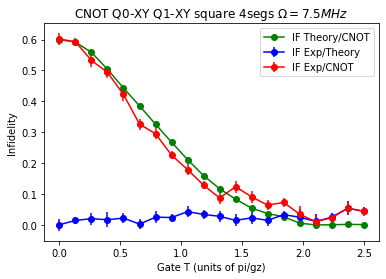

In [14]:
plt.errorbar(x=G_T_theory, y=G_IF_Exp_Theory, fmt='bo-', label='IF Exp/Theory', yerr=G_IF_Exp_Theory_STD)
plt.plot(G_T_theory, G_IF_Theory_TheoryGate, 'go-', label='IF Theory/CNOT')
plt.errorbar(x=G_T_theory, y=G_IF_Exp_TheoryGate, fmt='ro-', label='IF Exp/CNOT', yerr=G_IF_Exp_TheoryGate_STD)

plt.legend()
# plt.legend(['IF Theory/CNOT', 'IF Exp/CNOT'])
plt.title('CNOT Q0-XY Q1-XY square 4segs $\Omega=7.5MHz$ ')
plt.xlabel('Gate T (units of pi/gz)')
plt.ylabel('Infidelity')
plt.show()